In [1]:
!pip install resampy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install np_utils

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, f1_score, log_loss


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score


import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [6]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [7]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [8]:
len(df)

3480

In [9]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [10]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [01:34, 36.76it/s]


In [11]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [12]:
len(sorted_df)

3471

In [13]:
sorted_df.head(5)

,fs_id,slice_file_name,classID,fold,class,filepath,duration
0,iroar_123,iroar_123.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.785488
1,iroar_308,iroar_308.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.264354
2,grunt_878,grunt_878.wav,2,2,Grunt,/content/drive/MyDrive/ThesisData/File2/grunt_...,0.303628
3,roar_178,roar_178.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_1...,1.393515
4,roar_963,roar_963.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_9...,1.407211


In [14]:
df_class1 = sorted_df[sorted_df['class'] == 'IRoar']
df_class2 = sorted_df[sorted_df['class'] == 'Roar']
df_class3 = sorted_df[sorted_df['class'] == 'Grunt']

In [15]:
# Randomly select 900 samples from each class
sample_size = 900
df_class1_balanced = df_class1.sample(n=sample_size, random_state=42)
df_class2_balanced = df_class2.sample(n=sample_size, random_state=42)
df_class3_balanced = df_class3.sample(n=sample_size, random_state=42)

In [16]:
# Combine the balanced DataFrames into a single DataFrame
df_balanced = pd.concat([df_class1_balanced, df_class2_balanced, df_class3_balanced])

# Shuffle the combined DataFrame to mix the samples from all three classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [18]:
appended = []
for i in range(1,4):
    appended.append(df_balanced[df_balanced.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Roar,IRoar,Grunt
0,fold1,305,301,298
1,fold2,297,299,304
2,fold3,298,300,298


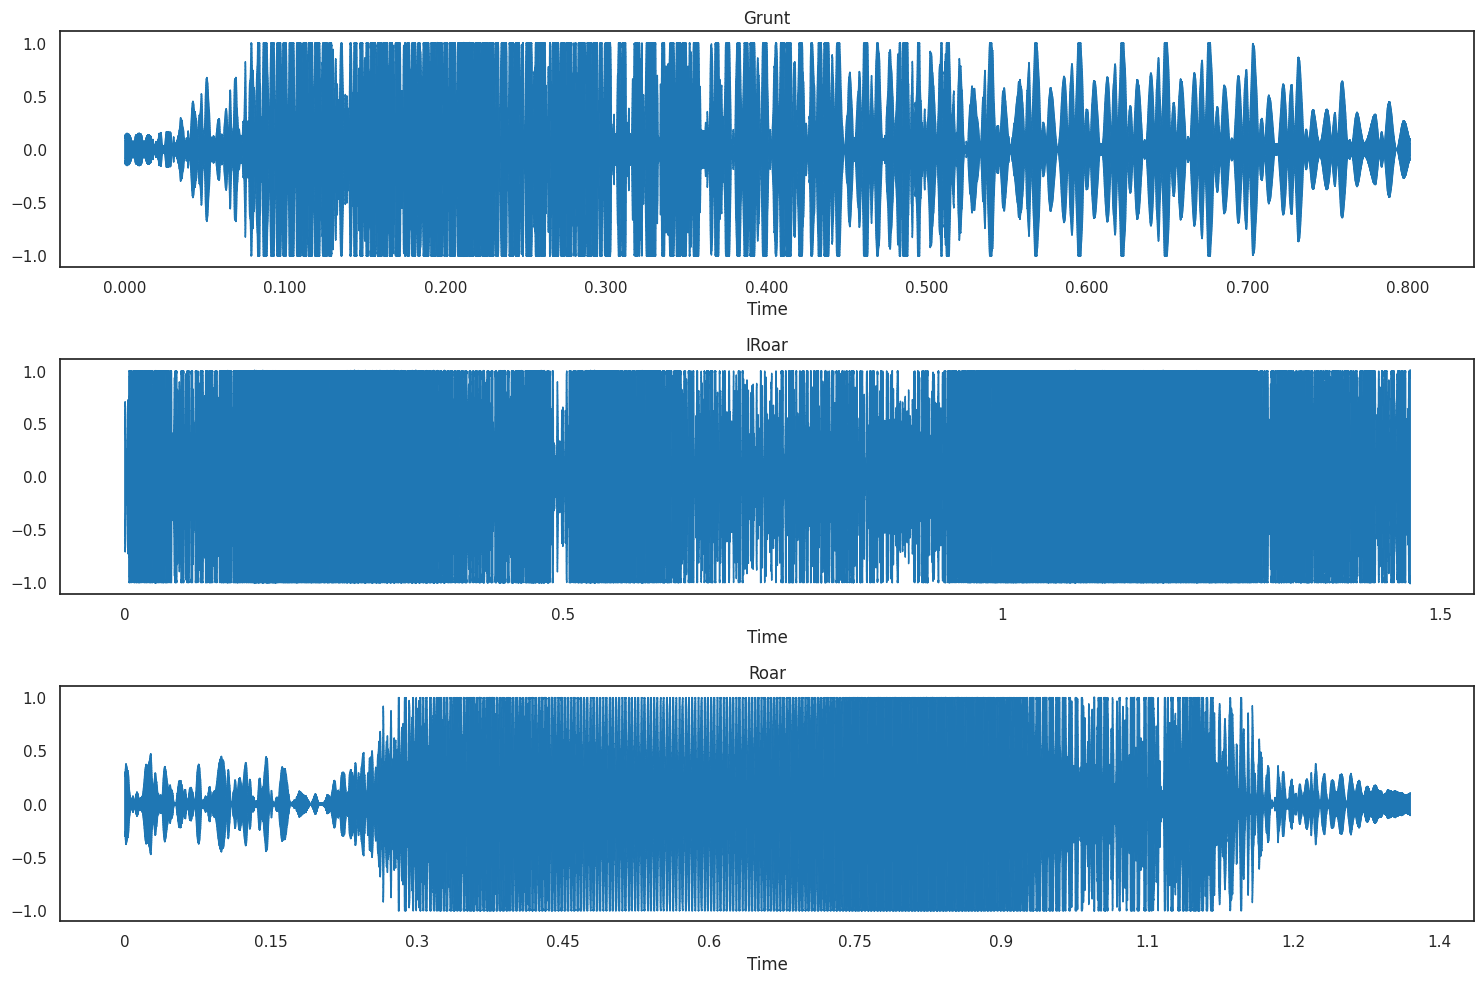

In [19]:
# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

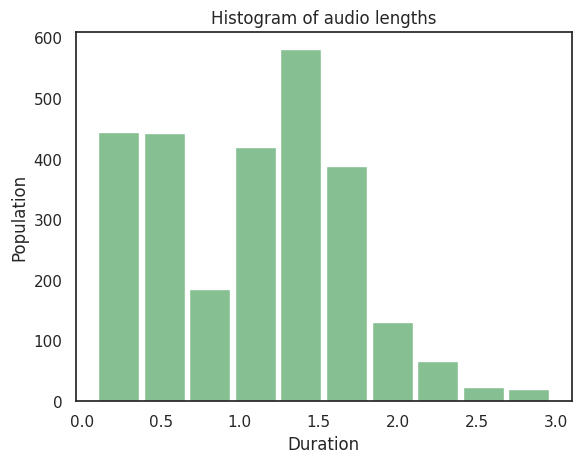

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 140
Lower than 2 but greater than 1 seconds: 1447
Lower than 1 seconds: 1113


In [20]:
plt.hist(df_balanced['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = df_balanced['duration'][(df_balanced['duration'] > 3)].count()
gt_2sec = df_balanced['duration'][(df_balanced['duration'] > 2) & (df_balanced['duration'] < 3)].count()
lt_2sec = df_balanced['duration'][(df_balanced['duration'] > 1) & (df_balanced['duration'] < 2)].count()
lt_1sec = df_balanced['duration'][df_balanced['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [21]:
df_balanced.head()

,fs_id,slice_file_name,classID,fold,class,filepath,duration
0,roar_276,roar_276.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_2...,2.337959
1,roar_76,roar_76.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_7...,1.623946
2,roar_314,roar_314.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_3...,1.236054
3,iroar_628,iroar_628.wav,1,2,IRoar,/content/drive/MyDrive/ThesisData/File2/iroar_...,1.789161
4,roar_784,roar_784.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_7...,1.567619


In [22]:
df_balanced.groupby(['class'])['duration'].max()

class
Grunt    1.696372
IRoar    2.971837
Roar     2.877506
Name: duration, dtype: float64

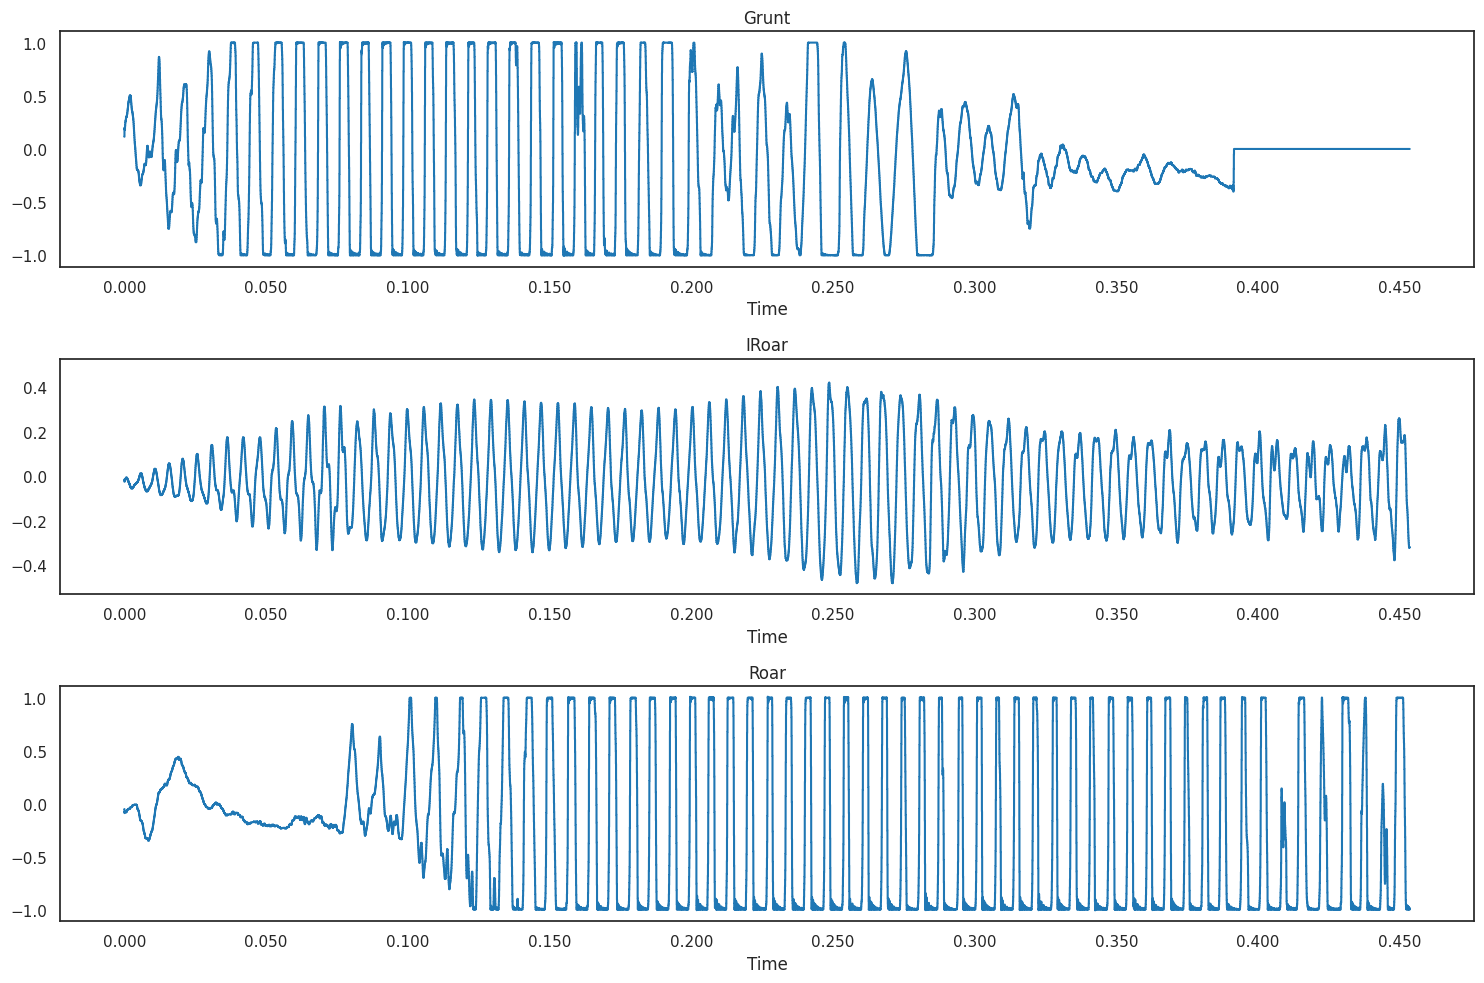

In [23]:
start = 0
end = 0
max_audio_duration = 3

# Randomly select one sample of each class
random_samples = df_balanced.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()


# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    y_trimmed, _ = librosa.effects.trim(audio_file)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sample_rate)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y_trimmed)), mode='constant')

    if labels[index] == "IRoar":
      start = 0
      end= 10000
    elif labels[index] == "Roar":
      start = 0
      end= 10000
    elif labels[index] == "Grunt":
      start = 0
      end= 10000
    librosa.display.waveshow(y=y_trimmed[start:end], sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

In [24]:
# Feature extraction using librosa

data = []
labels = []
max_audio_duration = 3

start = 0
end = 0

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(df_balanced))):
    fold_no=str(df_balanced.iloc[i]["fold"])
    file=df_balanced.iloc[i]["slice_file_name"]
    label=df_balanced.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)

    # Pad the audio to the maximum duration of 3 seconds
    max_samples = int(max_audio_duration * sr)
    y_trimmed = np.pad(y_trimmed, (0, max_samples - len(y)), mode='constant')

    if df_balanced.iloc[i]["class"] == "IRoar":
      start = 0
      end= 20000
    elif df_balanced.iloc[i]["class"] == "Roar":
      start = 0
      end= 20000
    elif df_balanced.iloc[i]["class"] == "Grunt":
      start = 0
      end= 20000
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)
    mfccs_std = np.std(librosa.feature.mfcc(y=y_trimmed[start:end], sr=sr, n_mfcc=13).T,axis=0)

    # Extract RMSE (temporal patterns)
    rmse_mean = np.mean(librosa.feature.rms(y=y_trimmed[start:end]))
    rmse_std = np.std(librosa.feature.rms(y=y_trimmed[start:end]))

    features = np.concatenate((mfccs_mean, mfccs_std, [rmse_mean, rmse_std]))

    data.append(features)
    labels.append(label)

100%|██████████| 2700/2700 [03:12<00:00, 14.03it/s]


In [25]:
data=np.array(data)
labels=np.array(labels)

In [26]:
data.shape, labels.shape

((2700, 28), (2700,))

In [27]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(labels)

In [28]:
from sklearn.utils.class_weight import compute_class_weight

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

In [32]:
# Lists to store accuracy, log loss, and confusion matrices for each binary classifier
accuracy_scores = []
log_loss_scores = []
confusion_matrices = []

# Initialize lists to store weights for each binary classifier
weights_A_vs_B_C = []
weights_B_vs_A_C = []
weights_C_vs_B_A = []

In [33]:
# Define the number of folds for cross-validation
n_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store evaluation metrics
accuracy_A_vs_B_C_scores = []
confusion_matrices_A_vs_B_C = []
loss_A_vs_B_C_scores = []
accuracy_B_vs_A_C_scores = []
confusion_matrices_B_vs_A_C = []
loss_B_vs_A_C_scores = []
accuracy_C_vs_B_A_scores = []
confusion_matrices_C_vs_B_A = []
loss_C_vs_B_A_scores = []

# Initialize Stratified K-Fold Cross-Validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a structured array with a field named 'Predicted_Grunt'
dtype = np.dtype([('Predicted_Grunt', 'U10')])  # 'U10' represents a Unicode string with a maximum length of 10 characters
predicted_grunt = np.empty(len(data), dtype=dtype)
dtype1 = np.dtype([('Predicted_Roar', 'U10')])  # 'U10' represents a Unicode string with a maximum length of 10 characters
predicted_roar = np.empty(len(data), dtype=dtype1)
dtype2 = np.dtype([('Predicted_IRoar', 'U10')])  # 'U10' represents a Unicode string with a maximum length of 10 characters
predicted_iroar = np.empty(len(data), dtype=dtype2)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [35]:
# Lists to store precision, recall, and F1 score for each binary classifier
precision_scores_A_vs_B_C = []
recall_scores_A_vs_B_C = []
f1_scores_A_vs_B_C = []

precision_scores_B_vs_A_C = []
recall_scores_B_vs_A_C = []
f1_scores_B_vs_A_C = []

precision_scores_C_vs_B_A = []
recall_scores_C_vs_B_A = []
f1_scores_C_vs_B_A = []

ensemble_precision = []
ensemble_recall = []
ensemble_f1 = []
confusion_matrices_ensemble = []

In [36]:
# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(data, y_encoded):
    # Split the data into train and test sets for this fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Calculate class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Initialize and train the SVM model for each class
    C_value = 1.0  # You can experiment with different C values

    # Data Preprocessing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the first SVM classifier for Class A vs. Class (B+C)
    svm_A_vs_B_C = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)
    svm_B_vs_A_C = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)
    svm_C_vs_B_A = SVC(kernel='rbf', C=C_value, class_weight='balanced', probability=True, random_state=42)

    # Create a new target variable for binary classification
    # 1 for Class A, 0 for Class (B+C)
    y_binary_train_A = [0 if label == 2 else 1 for label in y_train]
    y_binary_test_A = [0 if label == 2 else 1 for label in y_test]

    # 1 for Class A, 0 for Class (B+C)
    y_binary_train_B = [0 if label == 1 else 1 for label in y_train]
    y_binary_test_B = [0 if label == 1 else 1 for label in y_test]

    # 1 for Class C, 0 for Class (B+A)
    y_binary_train_C = [0 if label == 0 else 1 for label in y_train]
    y_binary_test_C = [0 if label == 0 else 1 for label in y_test]

    # Train the first SVM classifiers
    svm_A_vs_B_C.fit(X_train, y_binary_train_A)
    svm_B_vs_A_C.fit(X_train, y_binary_train_B)
    svm_C_vs_B_A.fit(X_train, y_binary_train_C)

    # Calculate accuracy for each binary classifier
    accuracy_A_vs_B_C = accuracy_score(y_binary_test_A, svm_A_vs_B_C.predict(X_test))
    accuracy_B_vs_A_C = accuracy_score(y_binary_test_B, svm_B_vs_A_C.predict(X_test))
    accuracy_C_vs_B_A = accuracy_score(y_binary_test_C, svm_C_vs_B_A.predict(X_test))

    # Store accuracy scores
    accuracy_scores.append((accuracy_A_vs_B_C, accuracy_B_vs_A_C, accuracy_C_vs_B_A))

    # Calculate log loss for each binary classifier
    prob_A_vs_B_C = svm_A_vs_B_C.predict_proba(X_test)  # Predicted probabilities
    loss_A_vs_B_C = log_loss(y_binary_test_A, prob_A_vs_B_C)

    prob_B_vs_A_C = svm_B_vs_A_C.predict_proba(X_test)
    loss_B_vs_A_C = log_loss(y_binary_test_B, prob_B_vs_A_C)

    prob_C_vs_B_A = svm_C_vs_B_A.predict_proba(X_test)
    loss_C_vs_B_A = log_loss(y_binary_test_C, prob_C_vs_B_A)

    # Store log loss scores
    log_loss_scores.append((loss_A_vs_B_C, loss_B_vs_A_C, loss_C_vs_B_A))

    # Calculate weights for each binary classifier based on accuracy
    total_accuracy_A = sum([accuracy[0] for accuracy in accuracy_scores])
    total_accuracy_B = sum([accuracy[1] for accuracy in accuracy_scores])
    total_accuracy_C = sum([accuracy[2] for accuracy in accuracy_scores])

    weights_A_vs_B_C.append(accuracy_A_vs_B_C / total_accuracy_A)
    weights_B_vs_A_C.append(accuracy_B_vs_A_C / total_accuracy_B)
    weights_C_vs_B_A.append(accuracy_C_vs_B_A / total_accuracy_C)

    # Store confusion matrices
    cm_A_vs_B_C = confusion_matrix(y_binary_test_A, svm_A_vs_B_C.predict(X_test))
    cm_B_vs_A_C = confusion_matrix(y_binary_test_B, svm_B_vs_A_C.predict(X_test))
    cm_C_vs_B_A = confusion_matrix(y_binary_test_C, svm_C_vs_B_A.predict(X_test))
    confusion_matrices.append((cm_A_vs_B_C, cm_B_vs_A_C, cm_C_vs_B_A))

    # Calculate precision, recall, and F1 score for each binary classifier
    precision_A_vs_B_C = precision_score(y_binary_test_A, svm_A_vs_B_C.predict(X_test))
    recall_A_vs_B_C = recall_score(y_binary_test_A, svm_A_vs_B_C.predict(X_test))
    f1_A_vs_B_C = f1_score(y_binary_test_A, svm_A_vs_B_C.predict(X_test))

    precision_B_vs_A_C = precision_score(y_binary_test_B, svm_B_vs_A_C.predict(X_test))
    recall_B_vs_A_C = recall_score(y_binary_test_B, svm_B_vs_A_C.predict(X_test))
    f1_B_vs_A_C = f1_score(y_binary_test_B, svm_B_vs_A_C.predict(X_test))

    precision_C_vs_B_A = precision_score(y_binary_test_C, svm_C_vs_B_A.predict(X_test))
    recall_C_vs_B_A = recall_score(y_binary_test_C, svm_C_vs_B_A.predict(X_test))
    f1_C_vs_B_A = f1_score(y_binary_test_C, svm_C_vs_B_A.predict(X_test))

    # Store precision, recall, and F1 scores for each binary classifier
    precision_scores_A_vs_B_C.append(precision_A_vs_B_C)
    recall_scores_A_vs_B_C.append(recall_A_vs_B_C)
    f1_scores_A_vs_B_C.append(f1_A_vs_B_C)

    precision_scores_B_vs_A_C.append(precision_B_vs_A_C)
    recall_scores_B_vs_A_C.append(recall_B_vs_A_C)
    f1_scores_B_vs_A_C.append(f1_B_vs_A_C)

    precision_scores_C_vs_B_A.append(precision_C_vs_B_A)
    recall_scores_C_vs_B_A.append(recall_C_vs_B_A)
    f1_scores_C_vs_B_A.append(f1_C_vs_B_A)

# Calculate the mean accuracy over all folds for each binary classifier
mean_accuracy_A_vs_B_C = np.mean([accuracy[0] for accuracy in accuracy_scores])
mean_accuracy_B_vs_A_C = np.mean([accuracy[1] for accuracy in accuracy_scores])
mean_accuracy_C_vs_B_A = np.mean([accuracy[2] for accuracy in accuracy_scores])

# Calculate the mean log loss over all folds for each binary classifier
mean_log_loss_A_vs_B_C = np.mean([loss[0] for loss in log_loss_scores])
mean_log_loss_B_vs_A_C = np.mean([loss[1] for loss in log_loss_scores])
mean_log_loss_C_vs_B_A = np.mean([loss[2] for loss in log_loss_scores])

# Calculate the mean precision, recall, and F1 score over all folds for each binary classifier
mean_precision_A_vs_B_C = np.mean(precision_scores_A_vs_B_C)
mean_recall_A_vs_B_C = np.mean(recall_scores_A_vs_B_C)
mean_f1_A_vs_B_C = np.mean(f1_scores_A_vs_B_C)

mean_precision_B_vs_A_C = np.mean(precision_scores_B_vs_A_C)
mean_recall_B_vs_A_C = np.mean(recall_scores_B_vs_A_C)
mean_f1_B_vs_A_C = np.mean(f1_scores_B_vs_A_C)

mean_precision_C_vs_B_A = np.mean(precision_scores_C_vs_B_A)
mean_recall_C_vs_B_A = np.mean(recall_scores_C_vs_B_A)
mean_f1_C_vs_B_A = np.mean(f1_scores_C_vs_B_A)

# Create a weighted voting ensemble classifier using calculated weights
ensemble_classifier = VotingClassifier(estimators=[
    ('Grunt', svm_A_vs_B_C),
    ('Roar', svm_B_vs_A_C),
    ('IRoar', svm_C_vs_B_A)
], voting='soft', weights=[weights_A_vs_B_C[-1], weights_B_vs_A_C[-1], weights_C_vs_B_A[-1]])

# Initialize lists to store ensemble accuracy and log loss
ensemble_accuracy = []
ensemble_log_loss = []

# Perform stratified k-fold cross-validation for the ensemble classifier
for train_index, test_index in skf.split(data, y_encoded):
    # Split the data into train and test sets for this fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Data Preprocessing
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the ensemble classifier
    ensemble_classifier.fit(X_train, y_train)

    # Make predictions with the ensemble classifier and precision, recall, and F1 score for the ensemble classifier
    ensemble_predictions = ensemble_classifier.predict(X_test)
    precision_ensemble = precision_score(y_test, ensemble_predictions, average='weighted')
    recall_ensemble = recall_score(y_test, ensemble_predictions, average='weighted')
    f1_ensemble = f1_score(y_test, ensemble_predictions, average='weighted')

    cm_ensemble = confusion_matrix(y_encoded[test_index], ensemble_predictions)
    confusion_matrices_ensemble.append(cm_ensemble)

    # Store precision, recall, and F1 scores for the ensemble classifier
    ensemble_precision.append(precision_ensemble)
    ensemble_recall.append(recall_ensemble)
    ensemble_f1.append(f1_ensemble)

    # Calculate accuracy for the ensemble
    ensemble_acc = accuracy_score(y_test, ensemble_predictions)
    ensemble_accuracy.append(ensemble_acc)

    # Calculate log loss for the ensemble
    ensemble_probabilities = ensemble_classifier.predict_proba(X_test)
    ensemble_loss = log_loss(y_test, ensemble_probabilities)
    ensemble_log_loss.append(ensemble_loss)

# Calculate the mean accuracy over all folds for the ensemble classifier
mean_ensemble_accuracy = np.mean(ensemble_accuracy)

# Calculate the mean log loss over all folds for the ensemble classifier
mean_ensemble_log_loss = np.mean(ensemble_log_loss)

# Calculate the mean precision, recall, and F1 score over all folds for the ensemble classifier
mean_precision_ensemble = np.mean(ensemble_precision)
mean_recall_ensemble = np.mean(ensemble_recall)
mean_f1_ensemble = np.mean(ensemble_f1)

# Print results
print("Accuracy scores for each fold for Grunt vs Not Grunt:", [item[0] for item in accuracy_scores])
print("Mean accuracy for Grunt vs Not Grunt:", mean_accuracy_A_vs_B_C)
print("Log Loss for each fold for Grunt vs Not Grunt:", [item[0] for item in log_loss_scores])
print("Mean log loss for Grunt vs Not Grunt:", mean_log_loss_A_vs_B_C)
print("Mean Precision for Grunt vs Not Grunt:", mean_precision_A_vs_B_C)
print("Mean Recall for Grunt vs Not Grunt:", mean_recall_A_vs_B_C)
print("Mean F1 Score for Grunt vs Not Grunt:", mean_f1_A_vs_B_C)
print('\n')

print("Accuracy scores for each fold for Roar vs Not Roar:", [item[1] for item in accuracy_scores])
print("Mean accuracy for Roar vs Not Roar:", mean_accuracy_B_vs_A_C)
print("Log Loss for each fold for Roar vs Not Roar:", [item[1] for item in log_loss_scores])
print("Mean log loss for Roar vs Not Roar:", mean_log_loss_B_vs_A_C)
print("Mean Precision for Roar vs Not Roar:", mean_precision_B_vs_A_C)
print("Mean Recall for Roar vs Not Roar:", mean_recall_B_vs_A_C)
print("Mean F1 Score for Roar vs Not Roar:", mean_f1_B_vs_A_C)
print('\n')

print("Accuracy scores for each fold for IRoar vs Not IRoar:", [item[2] for item in accuracy_scores])
print("Mean accuracy for IRoar vs Not IRoar:", mean_accuracy_C_vs_B_A)
print("Log Loss for each fold for IRoar vs Not IRoar:", [item[2] for item in log_loss_scores])
print("Mean log loss for IRoar vs Not IRoar:", mean_log_loss_C_vs_B_A)
print("Mean Precision for IRoar vs Not IRoar:", mean_precision_C_vs_B_A)
print("Mean Recall for IRoar vs Not IRoar:", mean_recall_C_vs_B_A)
print("Mean F1 Score for IRoar vs Not IRoar:", mean_f1_C_vs_B_A)
print('\n')

print("Accuracy scores for each fold for ensemble:", ensemble_accuracy)
print("Mean ensemble accuracy:", mean_ensemble_accuracy)
print("Log Loss for each fold for ensemble:", ensemble_log_loss)
print("Mean ensemble log loss:", mean_ensemble_log_loss)
print("Ensemble Precision:", mean_precision_ensemble)
print("Ensemble Recall:", mean_recall_ensemble)
print("Ensemble F1 Score:", mean_f1_ensemble)
print('\n')

# Print confusion matrices for both classifiers
for i, (cm_A_vs_B_C, cm_B_vs_A_C, cm_C_vs_B_A) in enumerate((confusion_matrices)):
    print(f"Fold {i + 1} - Confusion Matrix for Grunt vs Not Grunt:\n", cm_A_vs_B_C)
    print(f"Fold {i + 1} - Confusion Matrix for Roar vs Not Roar:\n", cm_B_vs_A_C)
    print(f"Fold {i + 1} - Confusion Matrix for IRoar vs Not IRoar:\n", cm_C_vs_B_A)
print('\n')

for i, cm in enumerate(confusion_matrices_ensemble):
    print(f"Fold {i + 1} - Ensemble Classifier:")
    print(cm)

Accuracy scores for each fold for Grunt vs Not Grunt: [0.9777777777777777, 0.9592592592592593, 0.9629629629629629, 0.975925925925926, 0.9629629629629629]
Mean accuracy for Grunt vs Not Grunt: 0.9677777777777777
Log Loss for each fold for Grunt vs Not Grunt: [0.06762975700333151, 0.11967203147951075, 0.11020651573298423, 0.08719767666633824, 0.1137007443642977]
Mean log loss for Grunt vs Not Grunt: 0.09968134504929249
Mean Precision for Grunt vs Not Grunt: 0.9863675839394623
Mean Recall for Grunt vs Not Grunt: 0.9650000000000001
Mean F1 Score for Grunt vs Not Grunt: 0.975550747899074


Accuracy scores for each fold for Roar vs Not Roar: [0.9185185185185185, 0.8944444444444445, 0.9277777777777778, 0.9222222222222223, 0.9018518518518519]
Mean accuracy for Roar vs Not Roar: 0.912962962962963
Log Loss for each fold for Roar vs Not Roar: [0.2103600291214214, 0.24848059330867597, 0.18793047481195851, 0.2038767473358399, 0.21761233961086315]
Mean log loss for Roar vs Not Roar: 0.21365203683775

In [37]:
# Plot confusion matrices
def plot_confusion_matrices(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    #sns.heatmap(np.round(cm).astype(int), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels); plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

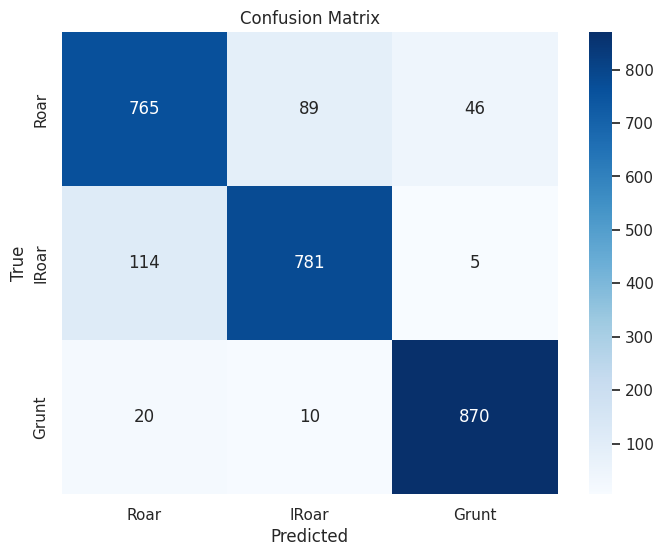

In [38]:
#Plot confusion matrix for Class A vs. Class (B+C)
plot_confusion_matrices(np.sum(confusion_matrices_ensemble, axis=0, dtype=np.int32), labels=['Roar', 'IRoar', 'Grunt'])

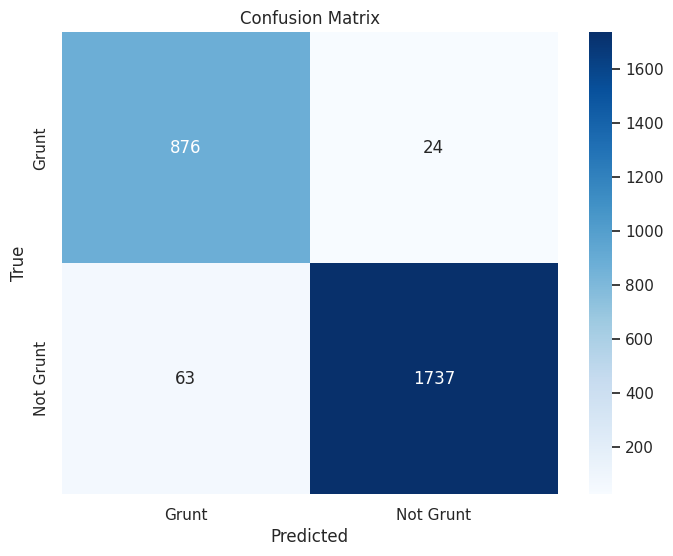

In [39]:
# Plot confusion matrix for Class A vs. Class (B+C)
plot_confusion_matrices(np.sum([item[0] for item in confusion_matrices], axis=0, dtype=np.int32), labels=['Grunt', 'Not Grunt'])

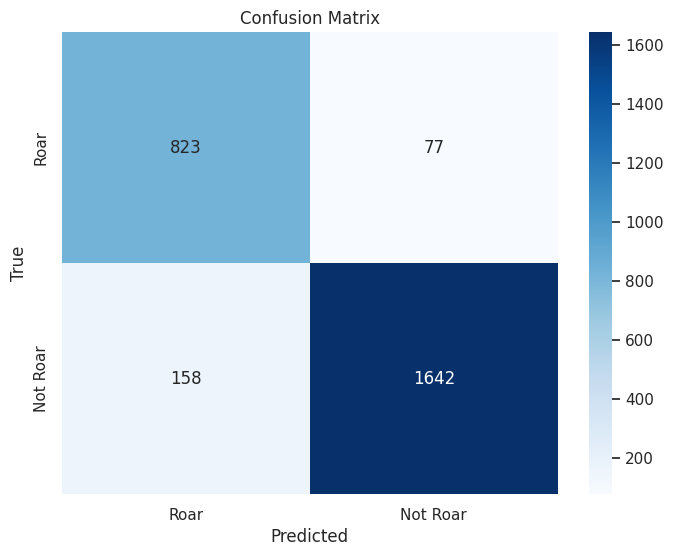

In [40]:
# Plot confusion matrix for Class B vs. Class (A+C)
plot_confusion_matrices(np.sum([item[1] for item in confusion_matrices], axis=0, dtype=np.int32), labels=['Roar', 'Not Roar'])

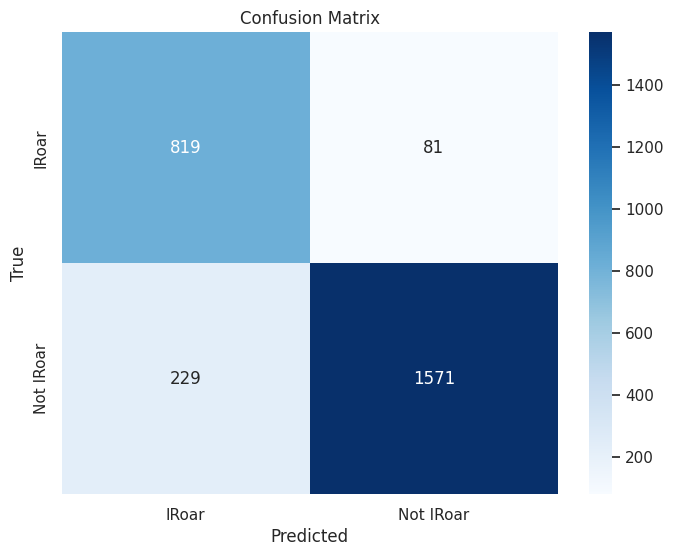

In [41]:
# Plot confusion matrix for Class C vs. Class (B+A)
plot_confusion_matrices(np.round(np.sum([item[2] for item in confusion_matrices], axis=0).astype(int)), labels=['IRoar','Not IRoar'])